In [317]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn import tree
from sklearn import svm
from sklearn.naive_bayes import ComplementNB,GaussianNB
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc
import time
import warnings
import os
import pickle
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from scipy import interp
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy.stats import ttest_ind

In [45]:
from warnings import filterwarnings
filterwarnings('ignore')

# Dataset Loading

In [46]:
df = pd.read_csv("./dataset_diabetes/diabetic_data.csv")
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


This is done to see what is inside the IDs_mapping.csv file


In [47]:
df1 = pd.read_csv("./dataset_diabetes/IDs_mapping.csv")
df1

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
...,...,...
62,22,Transfer from hospital inpt/same fac reslt in...
63,23,Born inside this hospital
64,24,Born outside this hospital
65,25,Transfer from Ambulatory Surgery Center


The list of column names

In [48]:
col=df.columns.tolist()
col

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted']

Data Distribution of the Class label

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64


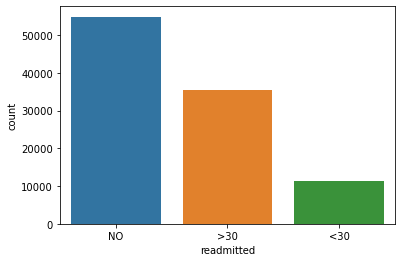

In [49]:
print(df.groupby(df["readmitted"]).size())
sns.countplot(df['readmitted'],label="Count")


A brief summary of all the features.

In [50]:
# for each column
for cols in list(df.columns):
    
    # get a list of unique values
    n = df[cols].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(cols)
        print(n)
    else:
        print(cols + ': ' +str(len(n)) + ' unique values')

encounter_id: 101766 unique values
patient_nbr: 71518 unique values
race
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male' 'Unknown/Invalid']
age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id
[6 1 2 3 4 5 8 7]
discharge_disposition_id
[25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id
[ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code
['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty: 73 unique values
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient

A function to check the missing values.

In [51]:
def missing_value_check(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data)

In [52]:
#missing data
df=df.replace('?', np.nan)
missing_value_check(df)

                          Total   Percent
weight                    98569  0.968585
medical_specialty         49949  0.490822
payer_code                40256  0.395574
race                       2273  0.022336
diag_3                     1423  0.013983
diag_2                      358  0.003518
diag_1                       21  0.000206
num_procedures                0  0.000000
max_glu_serum                 0  0.000000
number_diagnoses              0  0.000000
number_inpatient              0  0.000000
number_emergency              0  0.000000
number_outpatient             0  0.000000
num_medications               0  0.000000
readmitted                    0  0.000000
num_lab_procedures            0  0.000000
diabetesMed                   0  0.000000
time_in_hospital              0  0.000000
admission_source_id           0  0.000000
discharge_disposition_id      0  0.000000
admission_type_id             0  0.000000
age                           0  0.000000
gender                        0  0

In [53]:
# gender was coded differently so we use a custom count for this one            
print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count()) 

gender 3


In [54]:
#df.groupby('discharge_disposition_id').size()

# Missing Value handling

Deleting rows related to the death and hospice based on the IDs_mapping.csv

In [55]:
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [56]:
#removing invalid/unknown entries for gender
df=df[df['gender']!='Unknown/Invalid']
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


race and medical_specialty have missing data. elimating missing values of Race might create a bias towards specific races which is not preferable. And we don't want to miss out any unknown medical_speciality which might have missed out due to technical errors. So, it is better to replce the missing values withn 'UNK'. Weight has high percentage of missing value. So, instead of imputing this column it is better to drop this column. Then, payer code also has a high percentage of missing values and it it not important in case of readmission prediction.Missing rows of diagonosis has been removed .

In [57]:
# df.loc['race']=df.loc[df.race].replace('UNK','?')
# df.loc['medical_specialty'] = df.loc[df.medical_specialty].replace('UNK','?')
pd.options.mode.chained_assignment = None
df.race = df.race.fillna('UNK')
# #df.payer_code = df.payer_code.fillna('UNK')
df.medical_specialty = df.medical_specialty.fillna('UNK')

In [58]:
#dropping columns with high NA percentage
df.drop(['weight','payer_code'],axis=1,inplace=True)

# dropping rows of diag-1,diag-2, diag-3.
df.dropna(inplace=True)

Checking the missing values to see whehter any missing values left to handle or not.

In [59]:
missing_value_check(df)

                          Total  Percent
readmitted                    0      0.0
diabetesMed                   0      0.0
A1Cresult                     0      0.0
max_glu_serum                 0      0.0
number_diagnoses              0      0.0
diag_3                        0      0.0
diag_2                        0      0.0
diag_1                        0      0.0
number_inpatient              0      0.0
number_emergency              0      0.0
number_outpatient             0      0.0
num_medications               0      0.0
num_procedures                0      0.0
num_lab_procedures            0      0.0
medical_specialty             0      0.0
time_in_hospital              0      0.0
admission_source_id           0      0.0
discharge_disposition_id      0      0.0
admission_type_id             0      0.0
age                           0      0.0
gender                        0      0.0
race                          0      0.0
patient_nbr                   0      0.0
metformin       

In [60]:
df.shape

(97822, 48)

# Feature Engineering

In [61]:
#dropping columns with only one type of examples
# df = df.drop(['citoglipton', 'examide'], axis = 1)
# dropping columns related to IDs
df.drop(['encounter_id','patient_nbr'],axis=1,inplace=True)
df.shape

(97822, 46)

Investigating the medical_speciality column

In [62]:
print('Number medical specialty:', df.medical_specialty.nunique())
print(df.groupby('medical_specialty').size().sort_values(ascending = False)[0:40])

Number medical specialty: 73
medical_specialty
UNK                                  48149
InternalMedicine                     13987
Emergency/Trauma                      7350
Family/GeneralPractice                7111
Cardiology                            5247
Surgery-General                       2984
Nephrology                            1527
Orthopedics                           1366
Orthopedics-Reconstructive            1182
Radiologist                           1119
Pulmonology                            845
Psychiatry                             844
ObstetricsandGynecology                652
Urology                                646
Surgery-Cardiovascular/Thoracic        636
Gastroenterology                       534
Surgery-Vascular                       516
Surgery-Neuro                          430
PhysicalMedicineandRehabilitation      391
Oncology                               316
Pediatrics                             205
Neurology                              197
Hematol

There are 73 unique features of the medical speciality. And almost half of them are unknowns. And some of them have very few instanecs. In this project top 10 classes are being taken and rest of the classes are labeled as 'Other' here.

In [63]:
top_10 = ['UNK','InternalMedicine','Emergency/Trauma',\
          'Family/GeneralPractice', 'Cardiology','Surgery-General' ,\
          'Nephrology','Orthopedics',\
          'Orthopedics-Reconstructive','Radiologist']

# make a new column with duplicated data
df['med_spec'] = df['medical_specialty'].copy()

# replace all specialties not in top 10 with 'Other' category
df.loc[~df.med_spec.isin(top_10),'med_spec'] = 'Other'

df.drop('medical_specialty',axis=1,inplace=True)

In [64]:
df.groupby('med_spec').size()

med_spec
Cardiology                     5247
Emergency/Trauma               7350
Family/GeneralPractice         7111
InternalMedicine              13987
Nephrology                     1527
Orthopedics                    1366
Orthopedics-Reconstructive     1182
Other                          7800
Radiologist                    1119
Surgery-General                2984
UNK                           48149
dtype: int64

In [65]:
# deleted_columns = ['weight', 'citoglipton', 'examide', 'patient_nbr', 'payer_code', 'encounter_id']
# col = list(set(col) - set(deleted_columns))
# condition = df["diag_1"].str.contains('250')
# condition

In [66]:
df.shape

(97822, 46)

Grouping of the diag_1, diag_2, diag_3

First converted the value started with E, V replace them with a dash then converted a numeric value 250 as a string then converted all the values into float. Then it has been grouped as Diabetes, Circulatory, Respitratory, Digestive, Genitourinary, Injury, Muscoloskeletal, Neoplasms, Others based on the original papers.

In [67]:
diag_cols = ['diag_1','diag_2','diag_3']
for col in diag_cols:
    df[col] = df[col].str.replace('E','-')
    df[col] = df[col].str.replace('V','-')
    condition = df[col].str.contains('250')
    df.loc[condition,col] = '250'

df[diag_cols] = df[diag_cols].astype(float)


In [68]:
# diagnosis grouping
for col in diag_cols:
    #creating an extra column consist of nan this will help us to categories others later
    df['temp']=np.nan
    condition = df[col]==250
    df.loc[condition,'temp']='Diabetes'
    
    condition = (df[col]>=390) & (df[col]<=458) | (df[col]==785)
    df.loc[condition,'temp']='Circulatory'
    
    condition = (df[col]>=460) & (df[col]<=519) | (df[col]==786)
    df.loc[condition,'temp']='Respiratory'
    
    condition = (df[col]>=520) & (df[col]<=579) | (df[col]==787)
    df.loc[condition,'temp']='Digestive'
    
    condition = (df[col]>=580) & (df[col]<=629) | (df[col]==788)
    df.loc[condition,'temp']='Genitourinary'
    
    condition = (df[col]>=800) & (df[col]<=999)
    df.loc[condition,'temp']='Injury'
    
    condition = (df[col]>=710) & (df[col]<=739)
    df.loc[condition,'temp']='Muscoloskeletal'
    
    condition = (df[col]>=140) & (df[col]<=239)
    df.loc[condition,'temp']='Neoplasms'
    
    #converting all the rest values as Other
    condition = df[col]==0
    df.loc[condition,col]='?'
    df['temp']=df['temp'].fillna('Others')
    condition = df['temp']=='0'
    df.loc[condition,'temp']=np.nan
    #Replaceing temp in place of diagonisis
    df[col]=df['temp']
    df.drop('temp',axis=1,inplace=True)
#Droping the temp column
df.dropna(inplace=True)

In [69]:
df.shape

(97822, 46)

In [70]:
df.groupby(df["diag_1"]).size()

diag_1
Circulatory        29455
Diabetes            8039
Digestive           9221
Genitourinary       4960
Injury              6713
Muscoloskeletal     4836
Neoplasms           3088
Others             17693
Respiratory        13817
dtype: int64

Converting the numeric attributes into categorical.Because from the IDs_mapping.csv file we can see that these attributes are not representing a number. They are representing an indiviual entity.

In [71]:
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

df[cols_cat_num] = df[cols_cat_num].astype('str')

Age Has been given based on range. So, lets convert it into an ordinal number.

In [72]:
df["age"].value_counts()

[70-80)     25159
[60-70)     21864
[50-60)     16849
[80-90)     16328
[40-50)      9396
[30-40)      3605
[90-100)     2582
[20-30)      1507
[10-20)       468
[0-10)         64
Name: age, dtype: int64

In [73]:
labels = df['age'].astype('category').cat.categories.tolist()
replace_age = {'age' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df.replace(replace_age, inplace=True)

In [74]:
df.age.value_counts()

8     25159
7     21864
6     16849
9     16328
5      9396
4      3605
10     2582
3      1507
2       468
1        64
Name: age, dtype: int64

A1Cresult has 4 categorical values None, Norm, >7 ,  >8 Which looks like an ordinal feature. Because of that converting that categorical values into ordinal number. Then, Change and diabetesMed have two values (no&change) and (No, Yes). This can be encoded as -1 and 1. 24 drugs have 4 types of value Up, Down , Steady, No. Lets convert them into ordinal value because of their ordinal nature. 

In [75]:
A1Cresult_dict = {'None':0,
                  'Norm':5,
                  '>7':7,
                  '>8':8
                 }
df['A1Cresult'] = df['A1Cresult'].replace(A1Cresult_dict)

change_dict = {'No':-1,
               'Ch':1
              }
df['change'] = df['change'].replace(change_dict)

diabetesMed_dict = {'No':-1,
                    'Yes':1
                   }
df['diabetesMed'] = df['diabetesMed'].replace(diabetesMed_dict)
drugs_dict = {'Up':10,
        'Down':-10,
        'Steady':0,
        'No':-20
        }

drugs = ['metformin','repaglinide','nateglinide','chlorpropamide',
 'glimepiride','acetohexamide','glipizide','glyburide',
 'tolbutamide','pioglitazone','rosiglitazone','acarbose',
 'miglitol','troglitazone','tolazamide','examide',
 'citoglipton','insulin','glyburide-metformin','glipizide-metformin',
 'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']
for col in drugs:
    df[col] = df[col].replace(drugs_dict)




Seperating the label from the dataset

In [76]:
# df=df.drop(df.index[2])
# df=df.drop(df.index[3])

y = df.readmitted
x = df.drop('readmitted',axis=1)



# One-Hot encoding

one-hot encoding applied on the categorical features of the datasets.

In [77]:
cat_cols = list(df.select_dtypes('object').columns)
cat_cols.remove('readmitted')
cat_cols

['race',
 'gender',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'med_spec']

In [78]:
x=pd.get_dummies(x, columns=cat_cols)
#This x is my final dataset without labels
x

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult,...,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK
1,2,3,59,0,18,0,0,0,9,0,...,0,0,0,0,0,0,0,0,0,1
2,3,2,11,5,13,2,0,1,6,0,...,0,0,0,0,0,0,0,0,0,1
3,4,2,44,1,16,0,0,0,7,0,...,0,0,0,0,0,0,0,0,0,1
4,5,1,51,0,8,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,1
5,6,3,31,6,16,0,0,0,9,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,8,3,51,0,16,0,0,0,9,8,...,0,0,0,0,0,0,0,0,0,1
101762,9,5,33,3,18,0,0,1,9,0,...,0,0,0,0,0,0,0,0,0,1
101763,8,1,53,0,9,1,0,0,13,0,...,0,0,0,0,0,0,0,0,0,1
101764,9,10,45,2,21,0,0,1,9,0,...,0,0,0,0,0,0,0,0,1,0


In [79]:
#This is my final datalabels
np.unique(y)

array(['<30', '>30', 'NO'], dtype=object)

# Part A

# Initliazing my 6 classifiers

In [324]:
clf_dt = tree.DecisionTreeClassifier(criterion='gini',random_state=10)
clf_nb = GaussianNB()

clf_knn = KNeighborsClassifier(n_neighbors=7)
clf_rf = RandomForestClassifier( random_state=10)
clf_mlp= MLPClassifier(random_state=1,max_iter=200,verbose=False)

clf_xg_boost = xgb.XGBClassifier(n_estimators = 501, max_depth = 30, learning_rate = 0.01)

Splitting for the k folds crossvalidation.

In [81]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#kf = KFold(n_splits=10)

Function for the statistical significance

In [82]:
def statitical_significance(clf1_acc,clf2_acc,semi_supervised=False):
    if (semi_supervised==True):
        t,pvalue=ttest_ind(clf1_acc,clf2_acc,equal_var=False)
    else:
        t,pvalue=ttest_ind(clf1_acc,clf2_acc,equal_var=True)
    print(f'The P-value is = {pvalue}')
    print(f'The t-statistics is = {t}')
    if pvalue <= 0.05:
        print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.')
    else:
        print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.')

Function for calculating the Results.

In [84]:
def Results(cnf_matrix):
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy for each class
    ACC = (TP+TN)/(TP+FP+FN+TN)
    #Overall F1_socre
    f_score = (2*PPV*TPR)/(PPV+TPR) 
    return ACC,TPR,TNR,PPV,f_score

# Task1

The first task is focused on to predict the outcomes, in terms of patient
re-admissions. This is a multi-class learning problem, with three class labels {no,
readmitted within 30 days, readmitted after 30 days}.

My main function for doing the crossvalidaion

In [255]:
def crossvalidation3(X,Y,model,cv):
    
    j=0
    roc_auc = np.zeros((10,3))

    acc=[]
    rec= []
    spec = []
    prec = []
    f1_scores = []
    first=True
    n_classes=3
    tprs1=[]
    tprs2=[]
    tprs3=[]
    mean_fpr = np.linspace(0, 1, 100)
    start_time = time.time()
    for train_idx, test_idx, in cv.split(X, Y):
        x_train, y_train = X.iloc[train_idx], Y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], Y.iloc[test_idx]
        
        model.fit(x_train, y_train)
        predict = model.predict(x_test)
        y_score = model.predict_proba(x_test)
        #print(y_score.shape)
        
        cnf_matrix = confusion_matrix(y_test, predict,labels=['NO','>30','<30'])
        acc1,rec1,spec1,prec1,f1=Results(cnf_matrix) 

        print(f'For fold {j}:')
        print("Accuracy: "+repr(np.mean(acc1)))
        print("Sensitvity: "+repr(np.mean(rec1)))
        print("Specificity: "+repr(np.mean(spec1)))
        print("Precision: "+repr(np.mean(prec1)))
        print("F1_score: "+repr(np.mean(f1)))
#         roc_auc1= roc_auc_score(fpr1, rec1)   
    
        acc.append(acc1)
        rec.append(rec1)
        spec.append(spec1)
        prec.append(prec1)
        f1_scores.append(f1)
    
        y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
        
        #This is for the first class (NO)
        temp_fpr1, temp_tpr1, _ = roc_curve(y_test_dummies[:, 0], y_score[:, 0]) 
        roc_auc1 = auc(temp_fpr1, temp_tpr1)
        roc_auc[j][0]=roc_auc1  
        tprs1.append(interp(mean_fpr, temp_fpr1, temp_tpr1))
        tprs1[-1][0] = 0.0
        #This is for the second class (readmitted>30)
        temp_fpr2, temp_tpr2, _ = roc_curve(y_test_dummies[:, 1], y_score[:, 1])
        roc_auc2 = auc(temp_fpr2, temp_tpr2)
        tprs2.append(interp(mean_fpr, temp_fpr2, temp_tpr2))
        tprs2[-1][0] = 0.0
        roc_auc[j][1]=roc_auc2  
        #This is for the third class(readmitted<30)
        temp_fpr3, temp_tpr3, _ = roc_curve(y_test_dummies[:, 2], y_score[:, 2])
        roc_auc3 = auc(temp_fpr3, temp_tpr3)
        tprs3.append(interp(mean_fpr, temp_fpr3, temp_tpr3))
        tprs3[-1][0] = 0.0
        roc_auc[j][2]=roc_auc3  
        
        j=j+1 
    
    mean_tpr1 = np.mean(tprs1, axis=0)
    mean_tpr1[-1] = 1.0  
    
    mean_tpr2 = np.mean(tprs2, axis=0)
    mean_tpr2[-1] = 1.0  
  
    mean_tpr3 = np.mean(tprs3, axis=0)
    mean_tpr3[-1] = 1.0  
    


    multi_class_time = time.time() - start_time
    return  acc,rec,spec,prec,f1_scores,mean_tpr1,mean_tpr2,mean_tpr3,np.mean(roc_auc,axis=0),multi_class_time

# Training all of my classifiers

Here you can see the results for each folds. Overall summary (average) of the results will be shown later.

In [256]:
%%time
acc_dt,rec_dt,spec_dt,prec_dt,f1_score_dt,mean_tpr1_dt,mean_tpr2_dt,mean_tpr3_dt,roc_auc_dt,time_dt= crossvalidation3(x,y,clf_dt,skf)


For fold 0:
Accuracy: 0.6429861324065556
Sensitvity: 0.3872524651637419
Specificity: 0.6981754996201429
Precision: 0.385950735802719
F1_score: 0.3863040991391414
For fold 1:
Accuracy: 0.647892602814406
Sensitvity: 0.3826435102296892
Specificity: 0.7003982269860772
Precision: 0.38237542363254945
F1_score: 0.38248567654197724
For fold 2:
Accuracy: 0.6385878825052819
Sensitvity: 0.3767759321222461
Specificity: 0.6921714513182886
Precision: 0.37636602808713343
F1_score: 0.3764941325423896
For fold 3:
Accuracy: 0.641041368499966
Sensitvity: 0.3783475407225227
Specificity: 0.6940529402161717
Precision: 0.37790230281459253
F1_score: 0.3780860701448256
For fold 4:
Accuracy: 0.6385197301165406
Sensitvity: 0.3734102312683169
Specificity: 0.6915305925344599
Precision: 0.3732906879656679
F1_score: 0.3732535264181489
For fold 5:
Accuracy: 0.6486744360389832
Sensitvity: 0.38960112569114996
Specificity: 0.7001821815440188
Precision: 0.389216060752497
F1_score: 0.3893992470689449
For fold 6:
Accuracy:

In [258]:
%%time
acc_nb,rec_nb,spec_nb,prec_nb,f1_score_nb,mean_tpr1_nb,mean_tpr2_nb,mean_tpr3_nb,roc_auc_nb,time_nb= crossvalidation3(x,y,clf_nb,skf)


For fold 0:
Accuracy: 0.4188558383590582
Sensitvity: 0.3397204026912284
Specificity: 0.6697562607874797
Precision: 0.4421573764529884
F1_score: 0.09182948671222595
For fold 1:
Accuracy: 0.41701591195611437
Sensitvity: 0.338015648176907
Specificity: 0.6689235194625948
Precision: 0.43489476738976024
F1_score: 0.08728776062968581
For fold 2:
Accuracy: 0.41436652354665027
Sensitvity: 0.33609097564846063
Specificity: 0.6679369396804914
Precision: 0.4106544233658791
F1_score: 0.08112829729230082
For fold 3:
Accuracy: 0.4164792475976283
Sensitvity: 0.33449232558530806
Specificity: 0.6678728953890252
Precision: 0.38857415908737325
F1_score: 0.08673083470389731
For fold 4:
Accuracy: 0.4146391331016152
Sensitvity: 0.3354267032020564
Specificity: 0.6679358014040196
Precision: 0.41231308314751686
F1_score: 0.08250099105682786
For fold 5:
Accuracy: 0.4159340284876985
Sensitvity: 0.33768686947233917
Specificity: 0.6689248754669376
Precision: 0.46900139251120126
F1_score: 0.08539443842294947
For fold

In [259]:
%%time
acc_knn,rec_knn,spec_knn,prec_knn,f1_score_knn,mean_tpr1_knn,mean_tpr2_knn,mean_tpr3_knn,roc_auc_knn,time_knn= crossvalidation3(x,y,clf_knn,skf)


For fold 0:
Accuracy: 0.6607720876350132
Sensitvity: 0.3679864990280683
Specificity: 0.6891728681562456
Precision: 0.39284341130385986
F1_score: 0.36378913290896314
For fold 1:
Accuracy: 0.6660192851545198
Sensitvity: 0.3692405482839798
Specificity: 0.6948556758213565
Precision: 0.37339663026464476
F1_score: 0.3612505580685806
For fold 2:
Accuracy: 0.6635998091733115
Sensitvity: 0.3704325734149548
Specificity: 0.6937951849574947
Precision: 0.3808484534387481
F1_score: 0.3647620482526142
For fold 3:
Accuracy: 0.6613507803448511
Sensitvity: 0.36812582059954074
Specificity: 0.6902243333769206
Precision: 0.3874981865579808
F1_score: 0.36339293934816336
For fold 4:
Accuracy: 0.6683704763851973
Sensitvity: 0.37584896808136387
Specificity: 0.6975147734202657
Precision: 0.38960005990681873
F1_score: 0.3707581309464847
For fold 5:
Accuracy: 0.6644857902269474
Sensitvity: 0.37159434745538406
Specificity: 0.6935591236429334
Precision: 0.38701787291145745
F1_score: 0.3668674425018122
For fold 6:
A

In [257]:
%%time
acc_rf,rec_rf,spec_rf,prec_rf,f1_score_rf,mean_tpr1_rf,mean_tpr2_rf,mean_tpr3_rf,roc_auc_rf,time_rf= crossvalidation3(x,y,clf_rf,skf)


For fold 0:
Accuracy: 0.7137892262087294
Sensitvity: 0.4086553859457194
Specificity: 0.7257209456281117
Precision: 0.5514592353009862
F1_score: 0.3896951198980443
For fold 1:
Accuracy: 0.717946096970936
Sensitvity: 0.4134228136888782
Specificity: 0.7285329635137634
Precision: 0.5343333631709575
F1_score: 0.39529574799000017
For fold 2:
Accuracy: 0.7123287671232877
Sensitvity: 0.40674966008342656
Specificity: 0.724426375040371
Precision: 0.5483996549896962
F1_score: 0.38715580504296376
For fold 3:
Accuracy: 0.7126013766782525
Sensitvity: 0.40624966902033816
Specificity: 0.7245818508195677
Precision: 0.48526260782656294
F1_score: 0.3859646241299806
For fold 4:
Accuracy: 0.7173038915013971
Sensitvity: 0.412467319394626
Specificity: 0.7277911288195368
Precision: 0.540538508503586
F1_score: 0.39391803050093316
For fold 5:
Accuracy: 0.7207115109384583
Sensitvity: 0.41735329621378203
Specificity: 0.7316557478648419
Precision: 0.5534823433707405
F1_score: 0.3995782890004485
For fold 6:
Accurac

In [260]:
%%time
acc_mlp,rec_mlp,spec_mlp,prec_mlp,f1_score_mlp,mean_tpr1_mlp,mean_tpr2_mlp,mean_tpr3_mlp,roc_auc_mlp,time_mlp= crossvalidation3(x,y,clf_mlp,skf)


For fold 0:
Accuracy: 0.7159698797233296
Sensitvity: 0.409659723283178
Specificity: 0.7241781367379239
Precision: 0.5136594698655186
F1_score: 0.3931901952015597
For fold 1:
Accuracy: 0.7167876247913046
Sensitvity: 0.41290366098281805
Specificity: 0.7297987720415433
Precision: 0.46677490565243857
F1_score: 0.3950242382768389
For fold 2:
Accuracy: 0.7161453008927964
Sensitvity: 0.40959851322619606
Specificity: 0.7258886627839901
Precision: 0.4854446800034997
F1_score: 0.3915714009437424
For fold 3:
Accuracy: 0.7169631295576909
Sensitvity: 0.4197859322663265
Specificity: 0.7317022537072447
Precision: 0.49344965719571077
F1_score: 0.40769016394875623
For fold 4:
Accuracy: 0.7104205002385333
Sensitvity: 0.41546343632398974
Specificity: 0.7252947226609096
Precision: 0.486226387889574
F1_score: 0.40758243043885134
For fold 5:
Accuracy: 0.7208478157159409
Sensitvity: 0.4310483260898857
Specificity: 0.7378177614563458
Precision: 0.5313523136723568
F1_score: 0.4234724396378213
For fold 6:
Accur

In [261]:
%%time
acc_xg_boost,rec_xg_boost,spec_xg_boost,prec_xg_boost,f1_score_xg_boost,mean_tpr1_xg_boost,mean_tpr2_xg_boost,mean_tpr3_xg_boost,roc_auc_xg_boost,time_xg_boost= crossvalidation3(x,y,clf_xg_boost,skf)


For fold 0:
Accuracy: 0.7028859586357287
Sensitvity: 0.4068695936138338
Specificity: 0.7207082957982108
Precision: 0.4615372479748014
F1_score: 0.3979338086496365
For fold 1:
Accuracy: 0.7114041364271356
Sensitvity: 0.4240074761447887
Specificity: 0.7293251764771179
Precision: 0.4965259490871808
F1_score: 0.42092007052744024
For fold 2:
Accuracy: 0.7038097185306346
Sensitvity: 0.40997605617834626
Specificity: 0.7226193583047681
Precision: 0.4542801350054709
F1_score: 0.40234876548157167
For fold 3:
Accuracy: 0.7049683091392355
Sensitvity: 0.4116577126203673
Specificity: 0.7238922792395549
Precision: 0.4561252579114048
F1_score: 0.40397203549572064
For fold 4:
Accuracy: 0.7026511279220337
Sensitvity: 0.411075437917157
Specificity: 0.7210967170308566
Precision: 0.47058954867611896
F1_score: 0.4057338912315227
For fold 5:
Accuracy: 0.7094663667961562
Sensitvity: 0.41835907903036423
Specificity: 0.7279031682863476
Precision: 0.48236970340853064
F1_score: 0.4122429038971677
For fold 6:
Accu

# Results Summary

This function will show the average results.

In [263]:
def summary(acc,rec,spec,prec,f1,auc,time):
    print("Accuracy: "+repr(np.mean(acc)))
    print("Sensitvity: "+repr(np.mean(rec)))
    print("Specificity: "+repr(np.mean(spec)))
    print("Precision: "+repr(np.mean(prec)))
    print("F1_score: "+repr(np.mean(f1)))
    print("AUC: "+repr(np.mean(auc)))
    print("Runtime: "+repr(time)+" seconds")
    

In [264]:
summary(acc_dt,rec_dt,spec_dt,prec_dt,f1_score_dt,roc_auc_dt,time_dt)

Accuracy: 0.643372614202257
Sensitvity: 0.38175062663373577
Specificity: 0.6963899466319068
Precision: 0.3812346554500147
F1_score: 0.3814177841461021
AUC: 0.5390702866328213
Runtime: 22.167691707611084 seconds


In [265]:
summary(acc_nb,rec_nb,spec_nb,prec_nb,f1_score_nb,roc_auc_nb,time_nb)

Accuracy: 0.41681146454286455
Sensitvity: 0.3377786219265835
Specificity: 0.6688520261323164
Precision: 0.43060801325517956
F1_score: 0.08694773807076171
AUC: 0.5823768348392058
Runtime: 5.476387977600098 seconds


In [266]:
summary(acc_knn,rec_knn,spec_knn,prec_knn,f1_score_knn,roc_auc_knn,time_knn)

Accuracy: 0.6645676399709727
Sensitvity: 0.3713142248765065
Specificity: 0.6936490975601416
Precision: 0.3862517972419939
F1_score: 0.3659864796538309
AUC: 0.5568228325319081
Runtime: 554.6842091083527 seconds


In [267]:
summary(acc_rf,rec_rf,spec_rf,prec_rf,f1_score_rf,roc_auc_rf,time_rf)

Accuracy: 0.7156604129831339
Sensitvity: 0.410533030446578
Specificity: 0.7267646893557534
Precision: 0.5357294325912162
F1_score: 0.3916515766160952
AUC: 0.6545794426683561
Runtime: 207.14306545257568 seconds


In [268]:
summary(acc_mlp,rec_mlp,spec_mlp,prec_mlp,f1_score_mlp,roc_auc_mlp,time_mlp)

Accuracy: 0.7161647302102038
Sensitvity: 0.4151167797336395
Specificity: 0.7288179967330543
Precision: 0.49297321079826373
F1_score: 0.40023967013374107
AUC: 0.6605414114009006
Runtime: 2667.3309428691864 seconds


In [269]:
summary(acc_xg_boost,rec_xg_boost,spec_xg_boost,prec_xg_boost,f1_score_xg_boost,roc_auc_xg_boost,time_xg_boost)

Accuracy: 0.7059965825997234
Sensitvity: 0.41415520529321465
Specificity: 0.7241968270842516
Precision: 0.4740283909597311
F1_score: 0.40807213493648153
AUC: 0.6391600716539201
Runtime: 10039.373705863953 seconds


![alt text](./images/Task1.png "Title")

This is a summarized table of task1. This picture is being created using excel. Here we can see that Neural network is performing better than all other classifiers. Only in terms of f1-score Xg_boost is performing well. But again in terms of running time we can say that Neural network is the best classifier for the task1.

# ROC cruve for Task 1

In [234]:
mean_fpr = np.linspace(0, 1, 100)

Here roc curve of all the classifiers for class No are shown together.

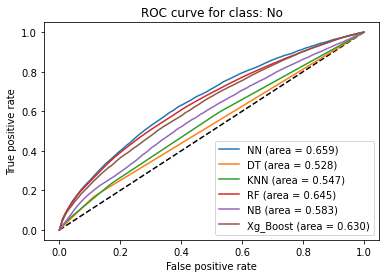

In [270]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(mean_fpr, mean_tpr1_mlp, label='NN (area = {:.3f})'.format(roc_auc_mlp[0]))
plt.plot(mean_fpr, mean_tpr1_dt, label='DT (area = {:.3f})'.format(roc_auc_dt[0]))
plt.plot(mean_fpr, mean_tpr1_knn, label='KNN (area = {:.3f})'.format(roc_auc_knn[0]))
plt.plot(mean_fpr, mean_tpr1_rf, label='RF (area = {:.3f})'.format(roc_auc_rf[0]))
plt.plot(mean_fpr, mean_tpr1_nb, label='NB (area = {:.3f})'.format(roc_auc_nb[0]))
plt.plot(mean_fpr, mean_tpr1_xg_boost, label='Xg_Boost (area = {:.3f})'.format(roc_auc_xg_boost[0]))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for class: No')
plt.legend(loc='best')
plt.show()

From this ROC curve we can say that Neural Network has the best performance in terms of AUC.

Here roc curve of all the classifiers for class >30 are shown together.

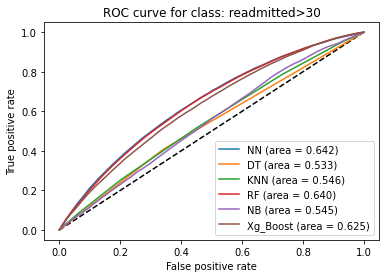

In [275]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(mean_fpr, mean_tpr2_mlp, label='NN (area = {:.3f})'.format(roc_auc_mlp[1]))
plt.plot(mean_fpr, mean_tpr2_dt, label='DT (area = {:.3f})'.format(mean_roc_auc2_dt))
plt.plot(mean_fpr, mean_tpr2_knn, label='KNN (area = {:.3f})'.format(roc_auc_knn[1]))
plt.plot(mean_fpr, mean_tpr2_rf, label='RF (area = {:.3f})'.format(mean_roc_auc2_rf))
plt.plot(mean_fpr, mean_tpr2_nb, label='NB (area = {:.3f})'.format(mean_roc_auc2_nb))
plt.plot(mean_fpr, mean_tpr2_xg_boost, label='Xg_Boost (area = {:.3f})'.format(roc_auc_xg_boost[1]))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for class: readmitted>30')
plt.legend(loc='best')
plt.show()

Random forest did well for >30 class but again here also Neural Network has outperformed all other classfiers.

Here roc curve of all the classifiers for class <30 are shown together.

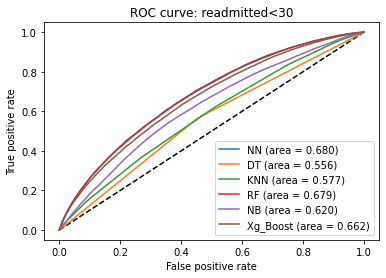

In [277]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(mean_fpr, mean_tpr3_mlp, label='NN (area = {:.3f})'.format(roc_auc_mlp[2]))
plt.plot(mean_fpr, mean_tpr3_dt, label='DT (area = {:.3f})'.format(roc_auc_dt[2]))
plt.plot(mean_fpr, mean_tpr3_knn, label='KNN (area = {:.3f})'.format(roc_auc_knn[2]))
plt.plot(mean_fpr, mean_tpr3_rf, label='RF (area = {:.3f})'.format(roc_auc_rf[2]))
plt.plot(mean_fpr, mean_tpr3_nb, label='NB (area = {:.3f})'.format(roc_auc_nb[2]))
plt.plot(mean_fpr, mean_tpr3_xg_boost, label='Xg_Boost (area = {:.3f})'.format(roc_auc_xg_boost[2]))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: readmitted<30')
plt.legend(loc='best')
plt.show()

Here again, Neural Network has the best result. Based on all of these results it can be said that Neural Network is performing best for task1. The reason Neural network is performing better is that it has good adaptation capability with the complex data dsitributions.

# Statistical Significance test for Task1

converting into array.

In [327]:
acc_dt=np.asarray(acc_dt).reshape(10,3)
acc_nb=np.asarray(acc_nb).reshape(10,3)
acc_knn=np.asarray(acc_knn).reshape(10,3)
#acc_svm2=np.asarray(acc_svm2).reshape(10,3)
acc_mlp=np.asarray(acc_mlp).reshape(10,3)
acc_rf=np.asarray(acc_rf).reshape(10,3)
acc_xg_boost=np.asarray(acc_xg_boost).reshape(10,3)

In [328]:
print("Statistical Test for class label Readmitted No")
print("Decision Tree-Naive Bayes")
statitical_significance(acc_dt[:,0],acc_nb[:,0])
print("")
print("Decision Tree-KNN")
statitical_significance(acc_dt[:,0],acc_knn[:,0])
print("")
print("Decision Tree-Random Forest")
statitical_significance(acc_dt[:,0],acc_rf[:,0])
print("")

print("Decision Tree-Neural Network")
statitical_significance(acc_dt[:,0],acc_mlp[:,0])
print("")
print("Decision Tree-XG_boost")
statitical_significance(acc_dt[:,0],acc_rf[:,0])
print("")
print("Naive Bayes-KNN")
statitical_significance(acc_nb[:,0],acc_knn[:,0])
print("")
print("Naive Bayes-Random Forest")
statitical_significance(acc_nb[:,0],acc_rf[:,0])
print("")

print("Naive Bayes-Neural Network")
statitical_significance(acc_nb[:,0],acc_mlp[:,0])
print("")
print("Naive Bayes-XG_boost")
statitical_significance(acc_nb[:,0],acc_xg_boost[:,0])
print("")
print("KNN-Random Forest")
statitical_significance(acc_knn[:,0],acc_rf[:,0])
print("")

print("KNN-Neural Network")
statitical_significance(acc_knn[:,0],acc_mlp[:,0])
print("")
print("KNN-XG_boost")
statitical_significance(acc_knn[:,0],acc_xg_boost[:,0])
print("")

print("Random Forest-Neural Network")
statitical_significance(acc_rf[:,0],acc_mlp[:,0])
print("")
print("Random Forest-XG_boost")
statitical_significance(acc_rf[:,0],acc_xg_boost[:,0])
print("")


print("Neural Network- XG_boost")
statitical_significance(acc_mlp[:,0],acc_xg_boost[:,0])
print("")

Statistical Test for class label Readmitted No
Decision Tree-Naive Bayes
The P-value is = 2.6933372478104978e-17
The t-statistics is = 31.908692952274517
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-KNN
The P-value is = 0.8754800386896208
The t-statistics is = -0.1589475144010539
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.

Decision Tree-Random Forest
The P-value is = 8.084244763694816e-15
The t-statistics is = -23.06913755382763
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-Neural Network
The P-value is = 2.1673656799050507e-14
The t-statistics is = -21.79862615892676
Since p<0.05, We can reject the null-hypot

Here statistical significance test has been done based on class No. It can be seen that for Random Forest- Neural Network and Decision tree-KNN we cannot reject the null hypothesis.

In [326]:
print("Statistical Test for class label Readmitted >30")
print("Decision Tree-Naive Bayes")
statitical_significance(acc_dt[:,1],acc_nb[:,1])
print("")
print("Decision Tree-KNN")
statitical_significance(acc_dt[:,1],acc_knn[:,1])
print("")
print("Decision Tree-Random Forest")
statitical_significance(acc_dt[:,1],acc_rf[:,1])
print("")

print("Decision Tree-Neural Network")
statitical_significance(acc_dt[:,1],acc_mlp[:,1])
print("")
print("Decision Tree-XG_boost")
statitical_significance(acc_dt[:,1],acc_rf[:,1])
print("")
print("Naive Bayes-KNN")
statitical_significance(acc_nb[:,1],acc_knn[:,1])
print("")
print("Naive Bayes-Random Forest")
statitical_significance(acc_nb[:,1],acc_rf[:,1])
print("")

print("Naive Bayes-Neural Network")
statitical_significance(acc_nb[:,1],acc_mlp[:,1])
print("")
print("Naive Bayes-XG_boost")
statitical_significance(acc_nb[:,1],acc_xg_boost[:,1])
print("")
print("KNN-Random Forest")
statitical_significance(acc_knn[:,1],acc_rf[:,1])
print("")

print("KNN-Neural Network")
statitical_significance(acc_knn[:,1],acc_mlp[:,1])
print("")
print("KNN-XG_boost")
statitical_significance(acc_knn[:,1],acc_xg_boost[:,1])
print("")

print("Random Forest-Neural Network")
statitical_significance(acc_rf[:,1],acc_mlp[:,1])
print("")
print("Random Forest-XG_boost")
statitical_significance(acc_rf[:,1],acc_xg_boost[:,1])
print("")

print("Neural Network- XG_boost")
statitical_significance(acc_mlp[:,1],acc_xg_boost[:,1])
print("")

Statistical Test for class label Readmitted >30
Decision Tree-Naive Bayes
The P-value is = 6.146346268813714e-17
The t-statistics is = -30.4545277949487
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-KNN
The P-value is = 0.12700048059979957
The t-statistics is = -1.6000121640109837
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different.

Decision Tree-Random Forest
The P-value is = 9.10505117131615e-16
The t-statistics is = -26.134477986011245
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-Neural Network
The P-value is = 3.5645700829137532e-16
The t-statistics is = -27.566201285001224
Since p<0.05, We can reject the null-hypo

Random Forest-Neural Network, Decision tree-knn ,NaiveBayes-Random forest, and  Naive-bayes -Neural network has similar kind of distributions. It looks like Naive bayes bayes, random forest and Neural network have similar kind of performance for this class.


In [281]:
print("Statistical Test for class label Readmitted <30")
print("Decision Tree-Naive Bayes")
statitical_significance(acc_dt[:,2],acc_nb[:,2])
print("")
print("Decision Tree-KNN")
statitical_significance(acc_dt[:,2],acc_knn[:,2])
print("")
print("Decision Tree-Random Forest")
statitical_significance(acc_dt[:,2],acc_rf[:,2])
print("")

print("Decision Tree-Neural Network")
statitical_significance(acc_dt[:,2],acc_mlp[:,2])
print("")
print("Decision Tree-XG_boost")
statitical_significance(acc_dt[:,2],acc_rf[:,2])
print("")
print("Naive Bayes-KNN")
statitical_significance(acc_nb[:,2],acc_knn[:,2])
print("")
print("Naive Bayes-Random Forest")
statitical_significance(acc_nb[:,2],acc_rf[:,2])
print("")

print("Naive Bayes-Neural Network")
statitical_significance(acc_nb[:,2],acc_mlp[:,2])
print("")
print("Naive Bayes-XG_boost")
statitical_significance(acc_nb[:,2],acc_xg_boost[:,2])
print("")
print("KNN-Random Forest")
statitical_significance(acc_knn[:,2],acc_rf[:,2])
print("")

print("KNN-Neural Network")
statitical_significance(acc_knn[:,2],acc_mlp[:,2])
print("")
print("KNN-XG_boost")
statitical_significance(acc_knn[:,2],acc_xg_boost[:,2])
print("")

print("Random Forest-Neural Network")
statitical_significance(acc_rf[:,2],acc_mlp[:,2])
print("")
print("Random Forest-XG_boost")
statitical_significance(acc_rf[:,2],acc_xg_boost[:,2])
print("")

print("Neural Network- XG_boost")
statitical_significance(acc_mlp[:,2],acc_xg_boost[:,2])
print("")

Statistical Test for class label Readmitted <30
Decision Tree-Naive Bayes
The P-value is = 3.0502562402150685e-38
The t-statistics is = 468.99857411389445
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-KNN
The P-value is = 9.597173227270234e-21
The t-statistics is = -49.84236961462404
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-Random Forest
The P-value is = 7.059597791394243e-25
The t-statistics is = -84.7623775195265
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-Neural Network
The P-value is = 4.833946645327493e-24
The t-statistics is = -76.14862283555038
Since p<0.05

For this class we can succesfully reject all the null hypothesis. For this class all other classifiers provided different results.

# Task2

For this task I have decided 'Age' feature as my attribute label. As age has been given in 10 different age range, I made into three categories for the convenaince of the calculation. I made age into three categories: underage(0-20 years),adult (21-50 years), old(51-100 years). This age prediction will certainly help to understand which age group suffers mostly from the diabetes.

In [282]:
# x1=x[y!='NO']
# y1=x1.age
# x1 = pd.concat([x1,y[y!='NO']],axis=1)
# x1 = x1.drop('age',axis=1)
# x1.readmitted.value_counts()

In [283]:
#Seperating the label from the dataset and adding the readmission to the dataset
#for task 2 x1 is the whole dataset with the label and y1 is the datalabel
y1=x.age
x1 = pd.concat([x,y],axis=1)
x1 = x1.drop('age',axis=1)
x1

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult,metformin,...,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK,readmitted
1,3,59,0,18,0,0,0,9,0,-20,...,0,0,0,0,0,0,0,0,1,>30
2,2,11,5,13,2,0,1,6,0,-20,...,0,0,0,0,0,0,0,0,1,NO
3,2,44,1,16,0,0,0,7,0,-20,...,0,0,0,0,0,0,0,0,1,NO
4,1,51,0,8,0,0,0,5,0,-20,...,0,0,0,0,0,0,0,0,1,NO
5,3,31,6,16,0,0,0,9,0,-20,...,0,0,0,0,0,0,0,0,1,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,3,51,0,16,0,0,0,9,8,0,...,0,0,0,0,0,0,0,0,1,>30
101762,5,33,3,18,0,0,1,9,0,-20,...,0,0,0,0,0,0,0,0,1,NO
101763,1,53,0,9,1,0,0,13,0,0,...,0,0,0,0,0,0,0,0,1,NO
101764,10,45,2,21,0,0,1,9,0,-20,...,0,0,0,0,0,0,0,1,0,NO


In [284]:
#Categorizing age into three categories underage, adult and old
dict_map = {1:'underage', 2: 'underage',
            3: 'adult', 4: 'adult', 5: 'adult',
            6: 'old', 7: 'old', 8: 'old', 9: 'old', 10:'old'
    
}
y1=y1.map(dict_map).fillna(y1)

From the plot it can be seen that change label has a balanced distribution

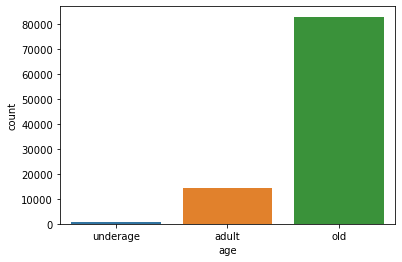

In [285]:
sns.countplot(y1,label="Count")

In [286]:
np.unique(y1)

array(['adult', 'old', 'underage'], dtype=object)

As readmitted feature is a categorical feature, It is better to use one hot encoder to store important information from them.

In [287]:
x1 = pd.get_dummies(x1,columns=['readmitted'])
x1

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult,metformin,...,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK,readmitted_<30,readmitted_>30,readmitted_NO
1,3,59,0,18,0,0,0,9,0,-20,...,0,0,0,0,0,0,1,0,1,0
2,2,11,5,13,2,0,1,6,0,-20,...,0,0,0,0,0,0,1,0,0,1
3,2,44,1,16,0,0,0,7,0,-20,...,0,0,0,0,0,0,1,0,0,1
4,1,51,0,8,0,0,0,5,0,-20,...,0,0,0,0,0,0,1,0,0,1
5,3,31,6,16,0,0,0,9,0,-20,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,3,51,0,16,0,0,0,9,8,0,...,0,0,0,0,0,0,1,0,1,0
101762,5,33,3,18,0,0,1,9,0,-20,...,0,0,0,0,0,0,1,0,0,1
101763,1,53,0,9,1,0,0,13,0,0,...,0,0,0,0,0,0,1,0,0,1
101764,10,45,2,21,0,0,1,9,0,-20,...,0,0,0,0,0,1,0,0,0,1


A crossvalidation function for the task2. Here for the evaluation purpose weighted score has been taken into account.

In [291]:
def crossvalidationTask2(X,Y,model,cv):
    
    j=0
    roc_auc = np.zeros((10,3))

    acc=[]
    rec= []
    spec = []
    prec = []
    f1_scores = []
    n_classes=3
    class_labels=['adult','old','underage']
    tprs1=[]
    tprs2=[]
    tprs3=[]
    mean_fpr = np.linspace(0, 1, 100)
    start_time = time.time()
    for train_idx, test_idx, in cv.split(X, Y):
        x_train, y_train = X.iloc[train_idx], Y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], Y.iloc[test_idx]
        
        model.fit(x_train, y_train)
        predict = model.predict(x_test)
        y_score = model.predict_proba(x_test)
        
        cnf_matrix = confusion_matrix(y_test, predict,labels=['adult','old','underage'])
        acc1,rec1,spec1,prec1,f1=Results(cnf_matrix) 
        rec1 = recall_score(y_test,predict,average='weighted')
        pec1 = precision_score(y_test,predict,average='weighted')
        f1 = f1_score(y_test,predict,average='weighted')

        print(f'For fold {j}:')
        print("Accuracy: "+repr(np.mean(acc1)))
        print("Sensitvity: "+repr(np.mean(rec1)))
        print("Specificity: "+repr(np.mean(spec1)))
        print("Precision: "+repr(np.mean(prec1)))
        print("F1_score: "+repr(np.mean(f1)))
        
        acc.append(acc1)
        rec.append(rec1)
        spec.append(spec1)
        prec.append(prec1)
        f1_scores.append(f1)
        
        y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
        #y_score = pd.get_dummies(predict, drop_first=False).values
        #This is for the first class (Adult)
        temp_fpr1, temp_tpr1, _ = roc_curve(y_test_dummies[:, 0], y_score[:, 0]) 
        roc_auc1 = auc(temp_fpr1, temp_tpr1)
        roc_auc[j][0]=roc_auc1 
        
        tprs1.append(interp(mean_fpr, temp_fpr1, temp_tpr1))
        tprs1[-1][0] = 0.0
        #This is for the second class (Old)
        temp_fpr2, temp_tpr2, _ = roc_curve(y_test_dummies[:, 1], y_score[:, 1])
        roc_auc2 = auc(temp_fpr2, temp_tpr2)
        roc_auc[j][1]=roc_auc2 
        
        tprs2.append(interp(mean_fpr, temp_fpr2, temp_tpr2))
        tprs2[-1][0] = 0.0
        #This is for the third class(Underage)
        temp_fpr3, temp_tpr3, _ = roc_curve(y_test_dummies[:, 2], y_score[:, 2])
        roc_auc3 = auc(temp_fpr3, temp_tpr3)
        roc_auc[j][2]=roc_auc3  
        
        tprs3.append(interp(mean_fpr, temp_fpr3, temp_tpr3))
        tprs3[-1][0] = 0.0
        
        j=j+1
        
    mean_tpr1 = np.mean(tprs1, axis=0)
    mean_tpr1[-1] = 1.0  
    
    mean_tpr2 = np.mean(tprs2, axis=0)
    mean_tpr2[-1] = 1.0  
  
    mean_tpr3 = np.mean(tprs3, axis=0)
    mean_tpr3[-1] = 1.0  
        

    multi_class_time = time.time() - start_time
    return  acc,rec,spec,prec,f1_scores,mean_tpr1,mean_tpr2,mean_tpr3,np.mean(roc_auc,axis=0),multi_class_time

# Training my classifiers

In [292]:
%%time
acc_dt2,rec_dt2,spec_dt2,prec_dt2,f1_score_dt2,mean_tpr1_dt2,mean_tpr2_dt2,mean_tpr3_dt2,roc_auc_dt2,total_time_dt2 = crossvalidationTask2(x1,y1,clf_dt,skf)

For fold 0:
Accuracy: 0.8515111247401955
Sensitvity: 0.7772666871102933
Specificity: 0.735881705799633
Precision: 0.4537066920624678
F1_score: 0.7825731482248717
For fold 1:
Accuracy: 0.8577123581723397
Sensitvity: 0.7865685372585096
Specificity: 0.7410876406019341
Precision: 0.4594785502434058
F1_score: 0.7896066560513713
For fold 2:
Accuracy: 0.860900974579159
Sensitvity: 0.7913514618687385
Specificity: 0.7431739312847868
Precision: 0.47026614279312295
F1_score: 0.7932101546804688
For fold 3:
Accuracy: 0.8562666121447556
Sensitvity: 0.7843999182171335
Specificity: 0.7473547295678805
Precision: 0.4926233386983238
F1_score: 0.7902924343560128
For fold 4:
Accuracy: 0.8598786887480406
Sensitvity: 0.7898180331220609
Specificity: 0.7520065046211707
Precision: 0.47570714077790804
F1_score: 0.7946333620838174
For fold 5:
Accuracy: 0.8541538880937777
Sensitvity: 0.7812308321406666
Specificity: 0.7424359872259761
Precision: 0.48816652862701443
F1_score: 0.7868762080696643
For fold 6:
Accuracy:

In [337]:
%%time
acc_knn2,rec_knn2,spec_knn2,prec_knn2,f1_score_knn2,mean_tpr1_knn2,mean_tpr2_knn2,mean_tpr3_knn2,roc_auc_knn2,total_time_knn2 = crossvalidationTask2(x1,y1,clf_knn,skf)

For fold 0:
Accuracy: 0.8961463763671675
Sensitvity: 0.8442195645507513
Specificity: 0.6993151809534197
Precision: 0.49123895319339733
F1_score: 0.8009865427906826
For fold 1:
Accuracy: 0.8947153224982111
Sensitvity: 0.8420729837473168
Specificity: 0.6964772216903682
Precision: 0.5477748002968885
F1_score: 0.797950931318206
For fold 2:
Accuracy: 0.8945001022285831
Sensitvity: 0.8417501533428746
Specificity: 0.700180699840482
Precision: 0.4290069817102984
F1_score: 0.8006050388090012
For fold 3:
Accuracy: 0.8958631500034077
Sensitvity: 0.8437947250051114
Specificity: 0.6987957344985366
Precision: 0.5992576997045599
F1_score: 0.8007290112444423
For fold 4:
Accuracy: 0.8975669597219383
Sensitvity: 0.8463504395829073
Specificity: 0.7023501933609557
Precision: 0.5351936490078293
F1_score: 0.803567793166504
For fold 5:
Accuracy: 0.8966809786683023
Sensitvity: 0.8450214680024535
Specificity: 0.6972665501597924
Precision: 0.6565593281944567
F1_score: 0.8000895886436602
For fold 6:
Accuracy: 0.

In [338]:
%%time
acc_rf2,rec_rf2,spec_rf2,prec_rf2,f1_score_rf2,mean_tpr1_rf2,mean_tpr2_rf2,mean_tpr3_rf2,roc_auc_rf2,total_time_rf2 = crossvalidationTask2(x1,y1,clf_rf,skf)

For fold 0:
Accuracy: 0.9103206242120686
Sensitvity: 0.8654809363181029
Specificity: 0.7281367001159644
Precision: 0.8318689329203438
F1_score: 0.8288466079774699
For fold 1:
Accuracy: 0.9096391699887562
Sensitvity: 0.864458754983134
Specificity: 0.7270216452352205
Precision: 0.784453821083297
F1_score: 0.8276549606694243
For fold 2:
Accuracy: 0.9118108089688542
Sensitvity: 0.8677162134532815
Specificity: 0.7317574576138797
Precision: 0.7967229597128336
F1_score: 0.8324984578092579
For fold 3:
Accuracy: 0.9094936277516527
Sensitvity: 0.864240441627479
Specificity: 0.7263899379029336
Precision: 0.8105068464405892
F1_score: 0.8273242381601371
For fold 4:
Accuracy: 0.9111292850814422
Sensitvity: 0.8666939276221631
Specificity: 0.7364599537762649
Precision: 0.7325192939440092
F1_score: 0.8337259453033372
For fold 5:
Accuracy: 0.9108566755264773
Sensitvity: 0.8662850132897159
Specificity: 0.7315547914007966
Precision: 0.788475714517889
F1_score: 0.8311629889145522
For fold 6:
Accuracy: 0.90

In [296]:
%%time
acc_mlp2,rec_mlp2,spec_mlp2,prec_mlp2,f1_score_mlp2,mean_tpr1_mlp2,mean_tpr2_mlp2,mean_tpr3_mlp2,roc_auc_mlp2,total_time_mlp2 = crossvalidationTask2(x1,y1,clf_mlp,skf)

For fold 0:
Accuracy: 0.9058230263382057
Sensitvity: 0.8587345395073086
Specificity: 0.767095513967542
Precision: 0.7799502758688055
F1_score: 0.8433440059780919
For fold 1:
Accuracy: 0.906163753449862
Sensitvity: 0.859245630174793
Specificity: 0.7706222525805133
Precision: 0.6655553848002196
F1_score: 0.8443738607500576
For fold 2:
Accuracy: 0.9087439514754992
Sensitvity: 0.8631159272132488
Specificity: 0.7479660805950736
Precision: 0.6987618510860895
F1_score: 0.8376167280769172
For fold 3:
Accuracy: 0.908062427588087
Sensitvity: 0.8620936413821304
Specificity: 0.7400965509627309
Precision: 0.7564313230550516
F1_score: 0.8336604650777318
For fold 4:
Accuracy: 0.9079942751993458
Sensitvity: 0.8619914127990186
Specificity: 0.7701330782887479
Precision: 0.6424162387417113
F1_score: 0.8455789575764695
For fold 5:
Accuracy: 0.9099706944728414
Sensitvity: 0.8649560417092619
Specificity: 0.7557637129762352
Precision: 0.7091774867378242
F1_score: 0.8419397954989948
For fold 6:
Accuracy: 0.90

readmitted <30 and readmitted > 30 needed to renamed because xgboost doesn't support any feature name with '<' or '>' operator

In [297]:
x1 = x1.rename(columns={'readmitted_<30':'readmitted_greater_30','readmitted_>30':'readmitted_less_30'})

In [298]:
%%time
acc_xg_boost2,rec_xg_boost2,spec_xg_boost2,prec_xg_boost2,f1_score_xg_boost2,mean_tpr1_xg_boost2,mean_tpr2_xg_boost2,mean_tpr3_xg_boost2,roc_auc_xg_boost2,total_time_xg_boost2 = crossvalidationTask2(x1,y1,clf_xg_boost,skf)

For fold 0:
Accuracy: 0.906708916828512
Sensitvity: 0.8600633752427681
Specificity: 0.7407400929092977
Precision: 0.7540835344571164
F1_score: 0.8326262083754442
For fold 1:
Accuracy: 0.909094006610106
Sensitvity: 0.8636410099151589
Specificity: 0.7439794040523057
Precision: 0.7105172484554512
F1_score: 0.8360733833657298
For fold 2:
Accuracy: 0.9109929803039596
Sensitvity: 0.8664894704559395
Specificity: 0.7492864502985905
Precision: 0.7303330086734202
F1_score: 0.8405688166272366
For fold 3:
Accuracy: 0.9069038369794861
Sensitvity: 0.8603557554692292
Specificity: 0.7386898804992564
Precision: 0.7445415740857254
F1_score: 0.8321595608364836
For fold 4:
Accuracy: 0.9093573229741704
Sensitvity: 0.8640359844612554
Specificity: 0.7499550120718969
Precision: 0.7096596337960571
F1_score: 0.8390196323871918
For fold 5:
Accuracy: 0.9076535132556396
Sensitvity: 0.8614802698834594
Specificity: 0.7431256437895736
Precision: 0.7324194223058815
F1_score: 0.8345114154242801
For fold 6:
Accuracy: 0.

# Results summary of the Task2

In [329]:
summary(acc_dt2,rec_dt2,spec_dt2,prec_dt2,f1_score_dt2,roc_auc_dt2,total_time_dt2)

Accuracy: 0.8565285637891067
Sensitvity: 0.7847928456836601
Specificity: 0.7424651510929066
Precision: 0.4803912310863791
F1_score: 0.7890147713609579
AUC: 0.617609782989341
Runtime: 21.619189262390137 seconds


In [330]:
summary(acc_nb2,rec_nb2,spec_nb2,prec_nb2,f1_score_nb2,roc_auc_nb2,total_time_nb2)

Accuracy: 0.4246624887573464
Sensitvity: 0.13699373313601954
Specificity: 0.6787169534285968
Precision: 0.3538500768549663
F1_score: 0.1760823888257081
AUC: 0.6247105919547086
Runtime: 6.723054885864258 seconds


In [331]:
summary(acc_knn2,rec_knn2,spec_knn2,prec_knn2,f1_score_knn2,roc_auc_knn2,total_time_knn2)

Accuracy: 0.8951905793460894
Sensitvity: 0.8427858690191341
Specificity: 0.6972336228146504
Precision: 0.5627636292570019
F1_score: 0.799050175939929
AUC: 0.6658301256915259
Runtime: 585.4385480880737 seconds


In [332]:
summary(acc_rf2,rec_rf2,spec_rf2,prec_rf2,f1_score_rf2,roc_auc_rf2,total_time_rf2)

Accuracy: 0.9101429159702085
Sensitvity: 0.8652143739553129
Specificity: 0.7293345472606514
Precision: 0.801088237578345
F1_score: 0.8294992883526915
AUC: 0.8470829891754633
Runtime: 170.17395734786987 seconds


In [333]:
summary(acc_mlp2,rec_mlp2,spec_mlp2,prec_mlp2,f1_score_mlp2,roc_auc_mlp2,total_time_mlp2)

Accuracy: 0.9076486200492764
Sensitvity: 0.8614729300739145
Specificity: 0.7571102685170167
Precision: 0.7178617605793085
F1_score: 0.8403416088641317
AUC: 0.858166382297073
Runtime: 2562.570287466049 seconds


In [334]:
summary(acc_xg_boost2,rec_xg_boost2,spec_xg_boost2,prec_xg_boost2,f1_score_xg_boost2,roc_auc_xg_boost2,total_time_xg_boost2)

Accuracy: 0.9082687677749257
Sensitvity: 0.8624031516623886
Specificity: 0.7432722582753162
Precision: 0.7382074726680365
F1_score: 0.8352395686065837
AUC: 0.8442845421510752
Runtime: 6421.347946882248 seconds


![alt text](./images/Task2.png "Title for task2")

This is the summarized table for the task2. Here all the classifiers performed better than the task1 also here the results are weighted average.

# ROC curve for Task 2

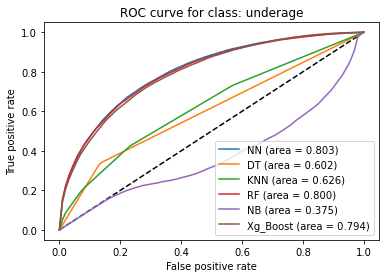

In [341]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(mean_fpr, mean_tpr1_mlp2, label='NN (area = {:.3f})'.format(roc_auc_mlp2[0]))
plt.plot(mean_fpr, mean_tpr1_dt2, label='DT (area = {:.3f})'.format(roc_auc_dt2[0]))
plt.plot(mean_fpr, mean_tpr1_knn2, label='KNN (area = {:.3f})'.format(roc_auc_knn2[0]))
plt.plot(mean_fpr, mean_tpr1_rf2, label='RF (area = {:.3f})'.format(roc_auc_rf2[0]))
plt.plot(mean_fpr, mean_tpr1_nb2, label='NB (area = {:.3f})'.format(roc_auc_nb2[0]))
plt.plot(mean_fpr, mean_tpr1_xg_boost2, label='Xg_Boost (area = {:.3f})'.format(roc_auc_xg_boost2[0]))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for class: underage')
plt.legend(loc='best')
plt.show()

This ROc curve is little weird. It can be seen that NB is performing very badly for this class. Other classifiers have almost consistent ROC. NN is outperforming all other classes in terms of AUC. And for an imbalance dataset like this AUC is a very important metrics.

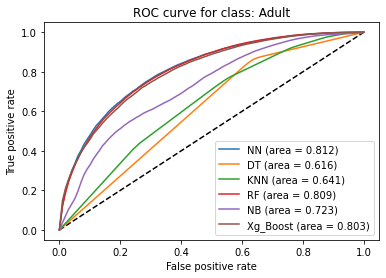

In [342]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(mean_fpr, mean_tpr2_mlp2, label='NN (area = {:.3f})'.format(roc_auc_mlp2[1]))
plt.plot(mean_fpr, mean_tpr2_dt2, label='DT (area = {:.3f})'.format(roc_auc_dt2[1]))
plt.plot(mean_fpr, mean_tpr2_knn2, label='KNN (area = {:.3f})'.format(roc_auc_knn2[1]))
plt.plot(mean_fpr, mean_tpr2_rf2, label='RF (area = {:.3f})'.format(roc_auc_rf2[1]))
plt.plot(mean_fpr, mean_tpr2_nb2, label='NB (area = {:.3f})'.format(roc_auc_nb2[1]))
plt.plot(mean_fpr, mean_tpr2_xg_boost2, label='Xg_Boost (area = {:.3f})'.format(roc_auc_xg_boost2[1]))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for class: Adult')
plt.legend(loc='best')
plt.show()

NB performed better with this class because it is the majority class. It is evident that NB performs bad when there are very less data. Here also NN performs best in terms of AUC.

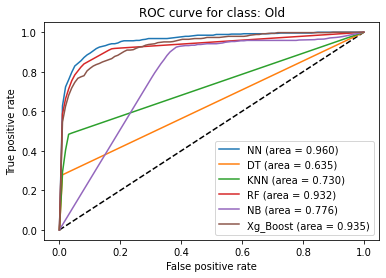

In [343]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(mean_fpr, mean_tpr3_mlp2, label='NN (area = {:.3f})'.format(roc_auc_mlp2[2]))
plt.plot(mean_fpr, mean_tpr3_dt2, label='DT (area = {:.3f})'.format(roc_auc_dt2[2]))
plt.plot(mean_fpr, mean_tpr3_knn2, label='KNN (area = {:.3f})'.format(roc_auc_knn2[2]))
plt.plot(mean_fpr, mean_tpr3_rf2, label='RF (area = {:.3f})'.format(roc_auc_rf2[2]))
plt.plot(mean_fpr, mean_tpr3_nb2, label='NB (area = {:.3f})'.format(roc_auc_nb2[2]))
plt.plot(mean_fpr, mean_tpr3_xg_boost2, label='Xg_Boost (area = {:.3f})'.format(roc_auc_xg_boost2[2]))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for class: Old')
plt.legend(loc='best')
plt.show()

In this ROC curve, Neural Network performed very well it has the best AUC among all other classes. With ample amount of data all classifiers tend to perform well.

# Statistical Difference for Task2

In [345]:
acc_dt2=np.asarray(acc_dt2).reshape(10,3)
acc_nb2=np.asarray(acc_nb2).reshape(10,3)
acc_knn2=np.asarray(acc_knn2).reshape(10,3)
#acc_svm2=np.asarray(acc_svm2).reshape(10,3)
acc_mlp2=np.asarray(acc_mlp2).reshape(10,3)
acc_rf2=np.asarray(acc_rf2).reshape(10,3)
acc_xg_boost2=np.asarray(acc_xg_boost2).reshape(10,3)

In [346]:
print("Statistical Test for class label Readmitted UnderAge")
print("Decision Tree-Naive Bayes")
statitical_significance(acc_dt2[:,0],acc_nb2[:,0])
print("")
print("Decision Tree-KNN")
statitical_significance(acc_dt2[:,0],acc_knn2[:,0])
print("")
print("Decision Tree-Random Forest")
statitical_significance(acc_dt2[:,0],acc_rf2[:,0])
print("")

print("Decision Tree-Neural Network")
statitical_significance(acc_dt2[:,0],acc_mlp2[:,0])
print("")
print("Decision Tree-XG_boost")
statitical_significance(acc_dt2[:,0],acc_rf2[:,0])
print("")
print("Naive Bayes-KNN")
statitical_significance(acc_nb2[:,0],acc_knn2[:,0])
print("")
print("Naive Bayes-Random Forest")
statitical_significance(acc_nb2[:,0],acc_rf2[:,0])
print("")

print("Naive Bayes-Neural Network")
statitical_significance(acc_nb2[:,0],acc_mlp2[:,0])
print("")
print("Naive Bayes-XG_boost")
statitical_significance(acc_nb2[:,0],acc_xg_boost2[:,0])
print("")
print("KNN-Random Forest")
statitical_significance(acc_knn2[:,0],acc_rf2[:,0])
print("")

print("KNN-Neural Network")
statitical_significance(acc_knn2[:,0],acc_mlp2[:,0])
print("")
print("KNN-XG_boost")
statitical_significance(acc_knn2[:,0],acc_xg_boost2[:,0])
print("")

print("Random Forest-Neural Network")
statitical_significance(acc_rf2[:,0],acc_mlp2[:,0])
print("")
print("Random Forest-XG_boost")
statitical_significance(acc_rf2[:,0],acc_xg_boost2[:,0])
print("")

print("Neural Network- XG_boost")
statitical_significance(acc_mlp2[:,0],acc_xg_boost2[:,0])
print("")

Statistical Test for class label Readmitted UnderAge
Decision Tree-Naive Bayes
The P-value is = 4.513174893757697e-21
The t-statistics is = 51.99028527536808
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-KNN
The P-value is = 4.127985130519593e-19
The t-statistics is = -40.37075297090205
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-Random Forest
The P-value is = 5.8775124775242835e-22
The t-statistics is = -58.26168924577423
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-Neural Network
The P-value is = 1.4527806918365786e-20
The t-statistics is = -48.69956441340223
Since 

For the underage class only NeuralNetwork and XG_boost has the similar type of results it also proves from their high performance against this class.

In [315]:
print("Statistical Test for class label Readmitted Adult")
print("Decision Tree-Naive Bayes")
statitical_significance(acc_dt2[:,1],acc_nb2[:,1])
print("")
print("Decision Tree-KNN")
statitical_significance(acc_dt2[:,1],acc_knn2[:,1])
print("")
print("Decision Tree-Random Forest")
statitical_significance(acc_dt2[:,1],acc_rf2[:,1])
print("")

print("Decision Tree-Neural Network")
statitical_significance(acc_dt2[:,1],acc_mlp2[:,1])
print("")
print("Decision Tree-XG_boost")
statitical_significance(acc_dt2[:,1],acc_rf2[:,1])
print("")
print("Naive Bayes-KNN")
statitical_significance(acc_nb2[:,1],acc_knn2[:,1])
print("")
print("Naive Bayes-Random Forest")
statitical_significance(acc_nb2[:,1],acc_rf2[:,1])
print("")

print("Naive Bayes-Neural Network")
statitical_significance(acc_nb2[:,1],acc_mlp2[:,1])
print("")
print("Naive Bayes-XG_boost")
statitical_significance(acc_nb2[:,1],acc_xg_boost2[:,1])
print("")
print("KNN-Random Forest")
statitical_significance(acc_knn2[:,1],acc_rf2[:,1])
print("")

print("KNN-Neural Network")
statitical_significance(acc_knn2[:,1],acc_mlp2[:,1])
print("")
print("KNN-XG_boost")
statitical_significance(acc_knn2[:,1],acc_xg_boost2[:,1])
print("")

print("Random Forest-Neural Network")
statitical_significance(acc_rf2[:,1],acc_mlp2[:,1])
print("")
print("Random Forest-XG_boost")
statitical_significance(acc_rf2[:,1],acc_xg_boost2[:,1])
print("")

print("Neural Network- XG_boost")
statitical_significance(acc_mlp2[:,1],acc_xg_boost2[:,1])
print("")

Statistical Test for class label Readmitted Adult
Decision Tree-Naive Bayes
The P-value is = 1.1710928291589888e-34
The t-statistics is = 296.4974012270929
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-KNN
The P-value is = 2.2042319254845944e-18
The t-statistics is = -36.74369065336329
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-Random Forest
The P-value is = 2.907670646439736e-21
The t-statistics is = -53.28381038388561
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-Neural Network
The P-value is = 3.4032651969514403e-20
The t-statistics is = -46.4334666661899
Since p<0

Again only Neural-Network and XG_boost has the similar performances.

In [316]:
print("Statistical Test for class label Readmitted old")
print("Decision Tree-Naive Bayes")
statitical_significance(acc_dt2[:,2],acc_nb2[:,2])
print("")
print("Decision Tree-KNN")
statitical_significance(acc_dt2[:,2],acc_knn2[:,2])
print("")
print("Decision Tree-Random Forest")
statitical_significance(acc_dt2[:,2],acc_rf2[:,2])
print("")

print("Decision Tree-Neural Network")
statitical_significance(acc_dt2[:,2],acc_mlp2[:,2])
print("")
print("Decision Tree-XG_boost")
statitical_significance(acc_dt2[:,2],acc_rf2[:,2])
print("")
print("Naive Bayes-KNN")
statitical_significance(acc_nb2[:,2],acc_knn2[:,2])
print("")
print("Naive Bayes-Random Forest")
statitical_significance(acc_nb2[:,2],acc_rf2[:,2])
print("")

print("Naive Bayes-Neural Network")
statitical_significance(acc_nb2[:,2],acc_mlp2[:,2])
print("")
print("Naive Bayes-XG_boost")
statitical_significance(acc_nb2[:,2],acc_xg_boost2[:,2])
print("")
print("KNN-Random Forest")
statitical_significance(acc_knn2[:,2],acc_rf2[:,2])
print("")

print("KNN-Neural Network")
statitical_significance(acc_knn2[:,2],acc_mlp2[:,2])
print("")
print("KNN-XG_boost")
statitical_significance(acc_knn2[:,2],acc_xg_boost2[:,2])
print("")

print("Random Forest-Neural Network")
statitical_significance(acc_rf2[:,2],acc_mlp2[:,2])
print("")
print("Random Forest-XG_boost")
statitical_significance(acc_rf2[:,2],acc_xg_boost2[:,2])
print("")

print("Neural Network- XG_boost")
statitical_significance(acc_mlp2[:,2],acc_xg_boost2[:,2])
print("")

Statistical Test for class label Readmitted old
Decision Tree-Naive Bayes
The P-value is = 3.450615977876742e-21
The t-statistics is = 52.77637163023433
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-KNN
The P-value is = 4.026551390149653e-09
The t-statistics is = -10.527359481931331
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-Random Forest
The P-value is = 8.075404346096741e-12
The t-statistics is = -15.42430181409354
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two algorithms are significantly different.

Decision Tree-Neural Network
The P-value is = 2.6935473679967e-10
The t-statistics is = -12.475292035981653
Since p<0.05,

RF-NN, RF-XG_boost, NN-XG_boost theses pairs cannot reject the null hypothesis which can infer that these three classifiers almost similar for this particular classes.

For the semi-supervised part check the other file.